# Face-Mask-Classification Project


Authors:
+ Tobias Palmowski
+ Fabian Metz
+ Thilo Sander

Date of Midterm-Report: 29.03.2021 <br>
Date of final submission: 26.04.2021


### Introduction

This Jupyter Notebook is the core of the Face-Mask-Classification Project performed in the class "Machine Learning" of the Hertie School in Berlin. There is one other Jupyter Notebook which deals with combining the different datasets into one large data set - a task only performed once and therefore outsourced to another file.

The following code is losely based on the chapter "Classification" from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow" by Aurélien Géron.

We included several hints were we are working on in yellow warning boxes.

<br>
<br>
<br>
<br>

### Preparation

<br>
This part loads the necessary libraries and packages as well as setting the Input and Output Directories.

In [19]:
# Import necessary libraries and set-up Jupyter NoteMasked-Face-Net-Datasetbook.

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
import timeit # To keep track of calculation time
import PIL #Python Image Library
import pickle

# to make this notebook's output stable across runs (safety measure)
np.random.seed(42)

In [20]:
# Switch between toy and full data
full_data_switch_on = False #Set True for full data set and False for Dummy Data set (see comment below)

<div class="alert alert-block alert-danger">
<b>Action required</b>
<p>
    
You have to set the switch whether you want to use the full dataset (True) or the dummy toy dataset (False). We set aside 100 correct and 100 incorrect pictures into a dummy toy data set in order to test our code faster. For running the algorithm with the dummy toy data everything is included in the GitHub-Repository (in the folder "01_data/99_dummy_toy_data"). The corresponding .pkl-file that include the output of the first Jupyter Notebook is included in the repository as well (in the folder "01_data/01_cleaned/")
    
However, if you want to run the algorithm with the full data set, you have to download the corresponding files under the Dropbox-Link below. The raw data is placed in the Dropbox folder "00_raw" (Hint: It is ca. 40,5 GB) and you have to download it into the repository folder "01_data/00_raw/". The corresponding pickle file (ca. 3,3 GB) is also available in the Dropbox-Folder under "01_cleaned". This file has to be placed in the corresponding repository folder to make this code run "01_data/01_cleaned/".

The reason why we cannot directly use the links here is that we do not have figured out yet how to loop through subfolders and files Dropbox online. GitHub does not allow us to upload such an amount of data.
<br>
Dropbox-Link: https://www.dropbox.com/sh/45vbkq1ihfnhqem/AAADdq6mJKaLsG1w7SDK-QV8a?dl=0    

<br>
<b>
!!!  Be aware: Running this Jupyter Notebook with the full data set requires several hours of runtime depending on your hardware !!!

</b>    
</div>

In [21]:
# Setting path variables depending on switch
if full_data_switch_on == True: 
    # Set path to full data set of correct and incorrect files
    ROOT_DATA = "01_data/00_raw/Masked-Face-Net-Dataset"
    PATH_DATA_CORRECT = os.path.join(ROOT_DATA + "/CMFD")
    PATH_DATA_INCORRECT = os.path.join(ROOT_DATA + "/IMFD")
else:
    # Set path to dummy toy data set of correct and incorrect files
    ROOT_DATA = "01_data/99_dummy_toy_data"
    PATH_DATA_CORRECT = os.path.join(ROOT_DATA + "/correct")
    PATH_DATA_INCORRECT = os.path.join(ROOT_DATA + "/incorrect")

# Where to save figures
ROOT_FIGS = "02_figures"
TOPIC_ID = "02_baseline"
IMAGES_PATH = os.path.join(ROOT_FIGS, TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Where to save general output (not figures)
ROOT_OUTPUT = "03_output"
TOPIC_ID = "01_eval_scores"
OUTPUT_PATH = os.path.join(ROOT_OUTPUT, TOPIC_ID)
os.makedirs(OUTPUT_PATH, exist_ok=True)

<br>
<br>
<br>
<br>

### Data Loading and Splitting

<br>
This part loads the necessary libraries and packages as well as setting the Input and Output Directories.

In [22]:
# Open pickle file containing the numerical data (depending on switch)
if full_data_switch_on == True: 
    pic_data = pickle.load(open(("01_data/01_cleaned/pic_data_full.pkl"),"rb"))
else: 
    pic_data = pickle.load(open(("01_data/01_cleaned/pic_data_dummy_toy.pkl"),"rb"))

<div class="alert alert-block alert-danger">
<b>Action required</b>
<p>
    
If you want to run the algorithm with the full data set, you have to download the corresponding pickle file (ca. 3,3 GB) from the Dropbox-Folder under "01_cleaned". This file has to be placed in the corresponding repository folder to make this code run "01_data/01_cleaned/".
<br>
Dropbox-Link: https://www.dropbox.com/sh/45vbkq1ihfnhqem/AAADdq6mJKaLsG1w7SDK-QV8a?dl=0    

<br>
<b>
!!!  Be aware: Running the this Jupyter Notebook with the full data set requires several hours of runtime depending on your hardware !!!

</b>    
</div>

In [23]:
# Copying dictionary data into separate data frames
rgb_data, labels = pic_data["rgb_data"], pic_data["labels"]

In [24]:
# Explore dimensionalities of data frames
print("Dimensions of rgb_data:", rgb_data.shape)
print("Dimensions of labels:", labels.shape)

Dimensions of rgb_data: (200, 3072)
Dimensions of labels: (200,)


In [25]:
# Split into test and training data set
from sklearn.model_selection import train_test_split

rgb_data_train, rgb_data_test, labels_train, labels_test = train_test_split(rgb_data, labels, test_size=0.10, random_state=42)

<br>
<br>
<br>
<br>

### Evaluating multiple untuned classifiers
<br>
In this section we define an array of initial classifiers and train them on our test data

In [26]:
#import classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#define classifiers
classifier_RandomForest = RandomForestClassifier(random_state=42)
classifier_LinSVC = svm.LinearSVC(max_iter=4000, tol=1e-3, random_state=42) #linear as normal (c based) is impractical using large datasets
classifier_DecTree = tree.DecisionTreeClassifier(random_state=42)
classifier_SGD = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# KNN had several hours runtime an kernel always died before finising
# classifier_KNN = KNeighborsClassifier(n_neighbors=1)
# LogReg hat several hours runtime an kernel always died before finishing
# classifier_LogReg = LogisticRegression(max_iter=2000, tol=1e-3,random_state=42)
classifiers= [classifier_RandomForest,classifier_LinSVC,classifier_DecTree,classifier_SGD]

In [27]:
# redefining labels as True False
labels_train_tf = (labels_train == 1)
labels_test_tf = (labels_test == 1)

In [28]:
# Start total timer
total_start_time = timeit.default_timer()

#intialize arrays and dictionaries 
evaluation_scores = {} # dictionary
confusion_matrices = [] 

# Import metrics and validation methods
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score


#training and evaluating classifiers
for classifier_x in classifiers:
    #Start timer
    loop_start_time = timeit.default_timer()
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print (">... Starting", classifier_name)
    
    #Train model
    classifier_x.fit(rgb_data_train, labels_train_tf) # train
    pred=cross_val_predict(classifier_x, rgb_data_train, labels_train_tf, cv = 3) # cross value prediction with 3 folds
    
    # store evaluation metrics 
    ps = precision_score(labels_train_tf, pred).round(3) 
    rs = recall_score(labels_train_tf, pred).round(3)
    cm = confusion_matrix(labels_train_tf, pred)
    cvs = cross_val_score(classifier_x, rgb_data_train, labels_train_tf, cv=3, scoring="accuracy").round(3)
    cvs_mean = cvs.mean().round(3)
    cvs_std = cvs.std().round(5)
    
    #store confusion matricies in vector
    confusion_matrices.append(cm)
    
    #End timer
    loop_elapsed = timeit.default_timer() - loop_start_time
    
    #store evaluation scores in global dicitonary 
    evaluation_scores[classifier_name]= [ps, rs, cvs, cvs_mean, cvs_std, round(loop_elapsed,2)]
    
    #store evaluation scores in pkl file to access them even when kernel dies afterwards
    if full_data_switch_on == True: 
        file = open(os.path.join(OUTPUT_PATH, "evaluation_scores.pkl"),"wb")
        pickle.dump(evaluation_scores, file)
        file.close()
    else:
        file = open(os.path.join(OUTPUT_PATH, "evaluation_scores_toy_dummy.pkl"),"wb")
        pickle.dump(evaluation_scores, file)
        file.close()
    
    #Print Status
    print(">...", round(loop_elapsed, 2) ,"seconds run time:", classifier_name)


#End timer
total_elapsed = timeit.default_timer() - total_start_time
print("Classifiers all finished. Run-time: ", round(total_elapsed,2))

>... Starting RandomForestClassifier
>... 1.08 seconds run time: RandomForestClassifier
>... Starting LinearSVC
>... 5.68 seconds run time: LinearSVC
>... Starting DecisionTreeClassifier
>... 0.3 seconds run time: DecisionTreeClassifier
>... Starting SGDClassifier
>... 0.06 seconds run time: SGDClassifier
Classifiers all finished. Run-time:  7.12


<div class="alert alert-block alert-warning">
<b>ATTENTION</b>
<p>
    
+ For loop that encompasses training and validating will be rewritten as function so that we can easier call it over and over again.    
</div>

<br>
<br>
<br>
<br>

### Creating output
<br>
In this section the output is displayed.

In [29]:
# creating and printing a table with the  evaluation scores
index = ["precision score", "recall score", "cross validation scores", "cross validation mean", "cross validation std", "run time in seconds"]
table_1 = pd.DataFrame(evaluation_scores, index)
table_1

,RandomForestClassifier,LinearSVC,DecisionTreeClassifier,SGDClassifier
precision score,0.946,0.957,0.946,0.884
recall score,0.978,0.989,0.967,0.933
cross validation scores,"[0.967, 0.967, 0.95]","[0.967, 0.983, 0.967]","[0.95, 0.95, 0.967]","[0.917, 0.917, 0.883]"
cross validation mean,0.961,0.972,0.956,0.906
cross validation std,0.00801,0.00754,0.00801,0.01603
run time in seconds,1.08,5.68,0.3,0.06


<div class="alert alert-block alert-warning">
<b>ATTENTION</b>
<p>
Table above will be redesigned in order to save it properly.
</div>

Saving figure 99_Toy_Dummy_RandomForestClassifier
Saving figure 99_Toy_Dummy_LinearSVC
Saving figure 99_Toy_Dummy_DecisionTreeClassifier
Saving figure 99_Toy_Dummy_SGDClassifier


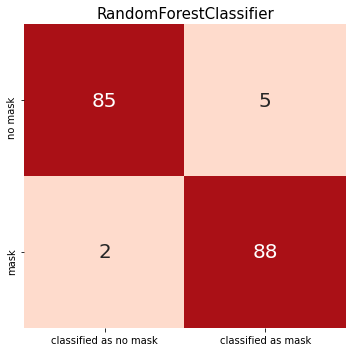

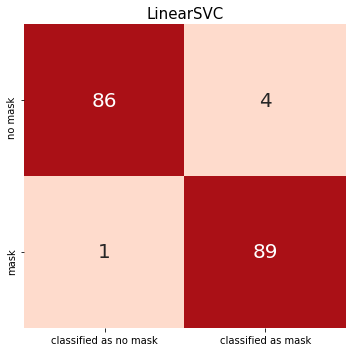

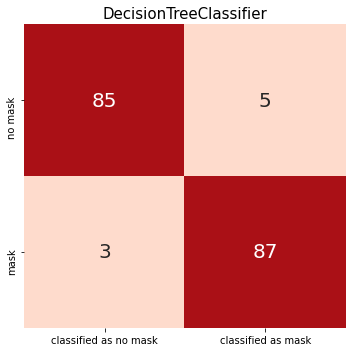

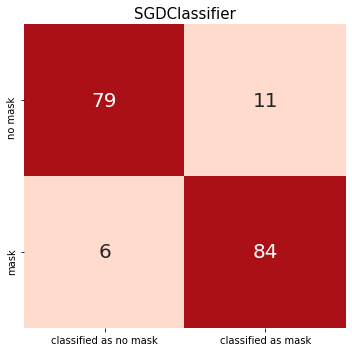

In [30]:
# creating confusion matrices with seaborn heatmaps
if full_data_switch_on == True: 
    for i in range(len(evaluation_scores)):
        classifier_name = str(classifiers[i]) # set classifier names
        classifier_name = classifier_name[:classifier_name.find("(")] 
        matrix = pd.DataFrame(confusion_matrices[i], columns = ["classified as no mask", "classified as mask"],
                                        index = ["no mask", "mask"])

        # Actual plot with seaborn
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        save_fig("{}".format(classifier_name))
else:
    for i in range(len(evaluation_scores)):
        classifier_name = str(classifiers[i]) # set classifier names
        classifier_name = classifier_name[:classifier_name.find("(")] 
        matrix = pd.DataFrame(confusion_matrices[i], columns = ["classified as no mask", "classified as mask"],
                                        index = ["no mask", "mask"])

        # Actual plot with seaborn
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        save_fig("99_Toy_Dummy_{}".format(classifier_name))

